In [166]:
import paddle
from numpy import savez

import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.loss import ExpecVal
from paddle_quantum.linalg import dagger
from paddle import matmul, trace

def Paddle_VQE(H, N, x, D=5, ITR=800, LR=0.04):
    r"""Main Learning network using dynamic graph
    Args:
        Hamiltonian: Hamiltonian
        N: Width of QNN
        D: Depth of QNN. Defaults to 2.
        ITR: Number of iterations. Defaults to 80.
        LR: Learning rate. Defaults to 0.2.
    """
    H = paddle.to_tensor(H, dtype=paddle_quantum.get_dtype())
    
    # Determine the dimensions of network
    net = Circuit(N)
    net.real_entangled_layer(depth=D)
    net.ry(qubits_idx='full')
    
    # Usually, we recommend Adam optimizer for better result. If you wish, you could use SGD or RMS prop.
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # Record optimization results
    summary_iter, summary_loss, summary_fid = [], [], []

    # Optimization iterations
    for itr in range(1, ITR + 1):
        U = net.unitary_matrix()
        # Run forward propagation to calculate loss function
        U_np = U.numpy().real
        state_vec = U_np[:,0]
        fidelity = abs(state_vec@x.T)**2
#         state = net()
#         loss = loss_func(state)
        loss_struct = paddle.real(matmul(matmul(dagger(U), H), U))
        loss = loss_struct[0][0]

        # In dynamic graph, run backward propagation to minimize loss function
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()

        # Update optimized results
        summary_loss.append(loss.numpy())
        summary_iter.append(itr)
        summary_fid.append(fidelity)

        # Print results
        if itr % 20 == 0:
            print("iter:", itr, "loss:", "%.4f" % loss.numpy())
            
    return state_vec, summary_iter, summary_loss, summary_fid

In [167]:
import numpy as np
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

N = 5   # number of qubits
dim = 2**N # dimension of the operator A

# Setup a tridiagonal matrix
k = [np.ones(dim-1), -2*np.ones(dim), np.ones(dim-1)]
offset = [-1, 0, 1]
A = diags(k,offset).toarray()

# Setup the driving term f(x) = x
b = np.linspace(0, 1, dim)
h = 1/(dim-1)
sampled_b = b*(h**2)
bt = np.linspace(0, 1, dim)

# Setup the Dirichlet B.C.s
phi_a, phi_b = 0, 0
sampled_b[0] -= phi_a
sampled_b[dim-1] -= phi_b
norm = np.linalg.norm(sampled_b)
sampled_b = sampled_b/norm

# Solve the linear system of equations
x = np.linalg.solve(A, sampled_b)
f = np.linalg.norm(x)
x = x/f

# Build Hamiltonian
sampled_b = sampled_b.reshape([dim, 1])
Hamiltonian = A@(np.eye(dim)- sampled_b@sampled_b.T)@A

In [168]:
quantum_solution, summary_iter, summary_loss, summary_fid =Paddle_VQE(Hamiltonian, N, x)

/Users/jacksong/opt/anaconda3/envs/paddle_quantum_env/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/jacksong/opt/anaconda3/envs/paddle_quantum_env/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


iter: 20 loss: 0.5621
iter: 40 loss: 0.1828
iter: 60 loss: 0.0961
iter: 80 loss: 0.0685
iter: 100 loss: 0.0519
iter: 120 loss: 0.0377
iter: 140 loss: 0.0276
iter: 160 loss: 0.0219
iter: 180 loss: 0.0190
iter: 200 loss: 0.0175
iter: 220 loss: 0.0168
iter: 240 loss: 0.0162
iter: 260 loss: 0.0157
iter: 280 loss: 0.0153
iter: 300 loss: 0.0148
iter: 320 loss: 0.0143
iter: 340 loss: 0.0138
iter: 360 loss: 0.0134
iter: 380 loss: 0.0129
iter: 400 loss: 0.0125
iter: 420 loss: 0.0122
iter: 440 loss: 0.0120
iter: 460 loss: 0.0118
iter: 480 loss: 0.0117
iter: 500 loss: 0.0116
iter: 520 loss: 0.0116
iter: 540 loss: 0.0115
iter: 560 loss: 0.0114
iter: 580 loss: 0.0113
iter: 600 loss: 0.0113
iter: 620 loss: 0.0112
iter: 640 loss: 0.0111
iter: 660 loss: 0.0110
iter: 680 loss: 0.0109
iter: 700 loss: 0.0108
iter: 720 loss: 0.0107
iter: 740 loss: 0.0106
iter: 760 loss: 0.0105
iter: 780 loss: 0.0104
iter: 800 loss: 0.0103


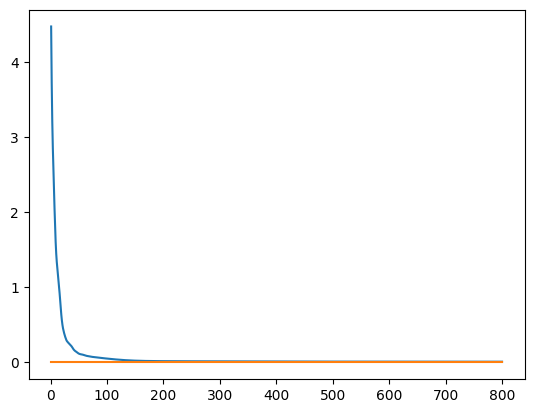

In [170]:
plt.plot(summary_iter, summary_loss)
plt.plot(summary_iter, np.zeros(len(summary_iter))) 

Text(50.5, 1.01, 'F=0.30711801')

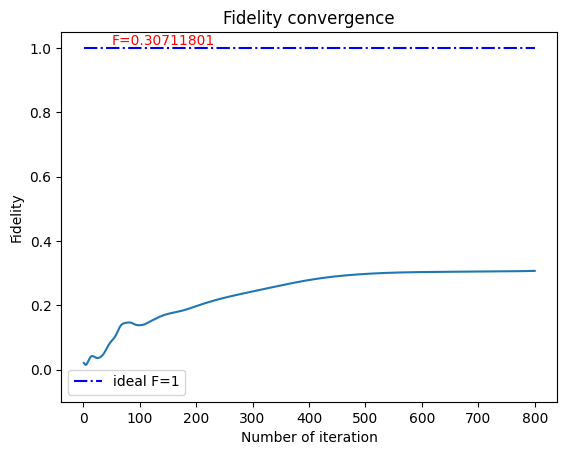

In [171]:
plt.plot(summary_iter, summary_fid)
plt.plot(summary_iter, np.ones(len(summary_iter)), 'b-.', label='ideal F=1')
plt.ylim([-0.1, 1.05])
plt.legend(loc="lower left")
plt.xlabel('Number of iteration')
plt.ylabel('Fidelity')
plt.title("Fidelity convergence")
plt.text(50.5, 1.01, f'F={summary_fid[-1]:.8f}', fontsize=10, color='r')
# plt.savefig("fid.png", bbox_inches='tight', dpi=300)

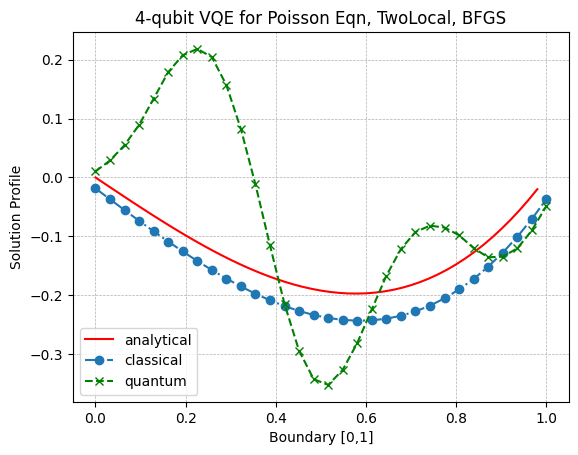

In [172]:
t = np.arange(0., 1., 0.02)
res = (t**3-t)/6
norm_res = np.linalg.norm(res)
res_norm = res/norm_res

xt = np.arange(0,1,1/dim)
exact = [1/6*(x**3-x) for x in np.arange(0,1,1/dim)]
norm = np.linalg.norm(exact)
exact = exact/norm

# red dashes, blue squares and green triangles
plt.plot(t, res_norm, 'r-', label='analytical')
plt.plot(bt, x, 'o-.', label='classical')
plt.plot(bt, quantum_solution, 'gx--', label='quantum')
# plt.legend()
plt.legend(loc="lower left")
plt.xlabel('Boundary [0,1]')
plt.ylabel('Solution Profile')
plt.title("4-qubit VQE for Poisson Eqn, TwoLocal, BFGS")
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()
# plt.savefig("Poisson.png", bbox_inches='tight', dpi=300)